In [133]:
import sl_rtd as sl
import user_trajectories as ut
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# __Author__: pablo-chacon
# __Version__: 1.0.0
# __Date__: 2024-05-23

sl.save_all_data()

Request URL: https://transport.integration.sl.se/v1/lines?transport_authority_id=1
  transport_mode  line_id     line_name designation            group_of_lines  \
0          metro       10    Blå linjen          10    Tunnelbanans blå linje   
1          metro       11    Blå linjen          11    Tunnelbanans blå linje   
2          metro       13   Röda linjen          13   Tunnelbanans röda linje   
3          metro       14   Röda linjen          14   Tunnelbanans röda linje   
4          metro       17  Gröna linjen          17  Tunnelbanans gröna linje   

   transport_authority_id    transport_authority_name  contractor_id  \
0                       1  Storstockholms Lokaltrafik           25.0   
1                       1  Storstockholms Lokaltrafik           25.0   
2                       1  Storstockholms Lokaltrafik           25.0   
3                       1  Storstockholms Lokaltrafik           25.0   
4                       1  Storstockholms Lokaltrafik           25.0  

(    transport_mode  line_id       line_name designation  \
 0            metro       10      Blå linjen          10   
 1            metro       11      Blå linjen          11   
 2            metro       13     Röda linjen          13   
 3            metro       14     Röda linjen          14   
 4            metro       17    Gröna linjen          17   
 ..             ...      ...             ...         ...   
 569           ship       89                          89   
 570           ship      260    Lisen/Lotten         260   
 571           ship      261  Fjäderholmarna         261   
 572          ferry      298                         298   
 573           taxi      299                         299   
 
                group_of_lines  transport_authority_id  \
 0      Tunnelbanans blå linje                       1   
 1      Tunnelbanans blå linje                       1   
 2     Tunnelbanans röda linje                       1   
 3     Tunnelbanans röda linje                

In [134]:
# Load the pickled data
timetable = pd.read_pickle('timetable.pkl')
ut_df = pd.read_pickle('gdf.pkl')
dest_df = pd.read_pickle('dest.pkl')
deviations = pd.read_pickle('deviations.pkl')
nearby_stops = pd.read_pickle('nearby_stops.pkl')

In [135]:
# Print out the data to inspect
print("Timetable DataFrame:")
print(timetable.head())

print("\nUser Trajectories DataFrame:")
print(ut_df.head())

print("\nDestinations DataFrame:")
print(dest_df.head())

print("\nDeviations DataFrame:")
print(deviations.head())

print("\nNearby Stops DataFrame:")
print(nearby_stops.head())

Timetable DataFrame:
  transport_mode  line_id     line_name designation            group_of_lines  \
0          metro       10    Blå linjen          10    Tunnelbanans blå linje   
1          metro       11    Blå linjen          11    Tunnelbanans blå linje   
2          metro       13   Röda linjen          13   Tunnelbanans röda linje   
3          metro       14   Röda linjen          14   Tunnelbanans röda linje   
4          metro       17  Gröna linjen          17  Tunnelbanans gröna linje   

   transport_authority_id    transport_authority_name  contractor_id  \
0                       1  Storstockholms Lokaltrafik           25.0   
1                       1  Storstockholms Lokaltrafik           25.0   
2                       1  Storstockholms Lokaltrafik           25.0   
3                       1  Storstockholms Lokaltrafik           25.0   
4                       1  Storstockholms Lokaltrafik           25.0   

  contractor_name           valid_from valid_to  
0        

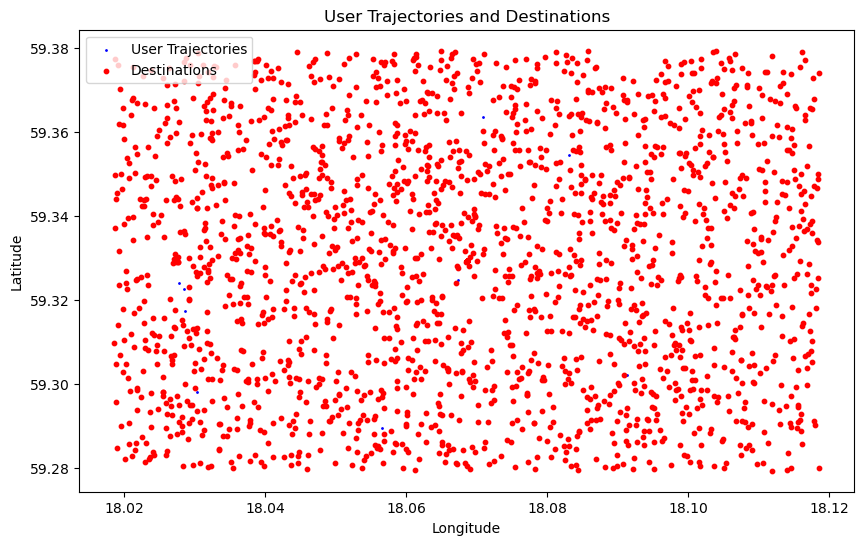

In [136]:
# Plotting the user trajectories
plt.figure(figsize=(10, 6))
plt.scatter(ut_df['Longitude'], ut_df['Latitude'], c='blue', label='User Trajectories', s=1)
plt.scatter(dest_df['Longitude'], dest_df['Latitude'], c='red', label='Destinations', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Trajectories and Destinations')
plt.legend()
plt.show()


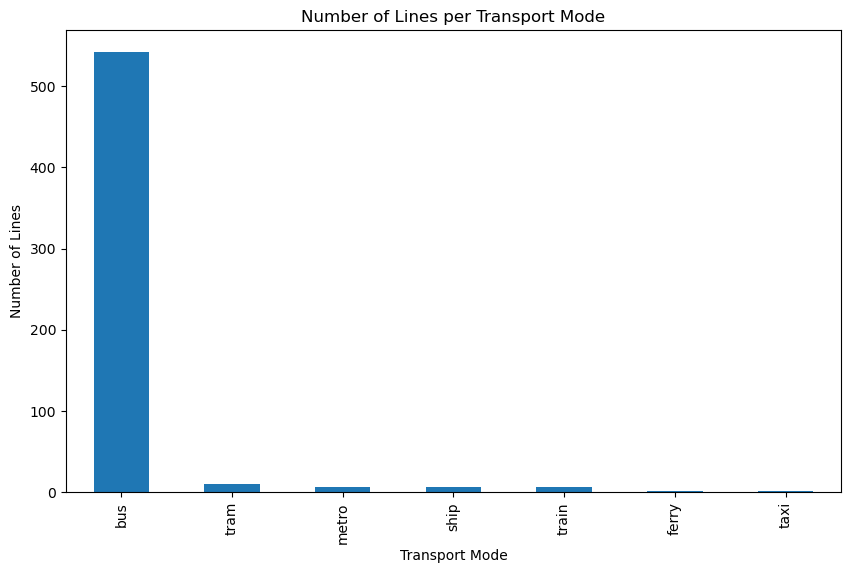

In [137]:
# Plotting the timetable data
plt.figure(figsize=(10, 6))
if 'transport_mode' in timetable.columns:
    timetable_modes = timetable['transport_mode'].value_counts()
    timetable_modes.plot(kind='bar')
    plt.xlabel('Transport Mode')
    plt.ylabel('Number of Lines')
    plt.title('Number of Lines per Transport Mode')
    plt.show()
else:
    print("The column 'transport_mode' is not present in timetable_df.")

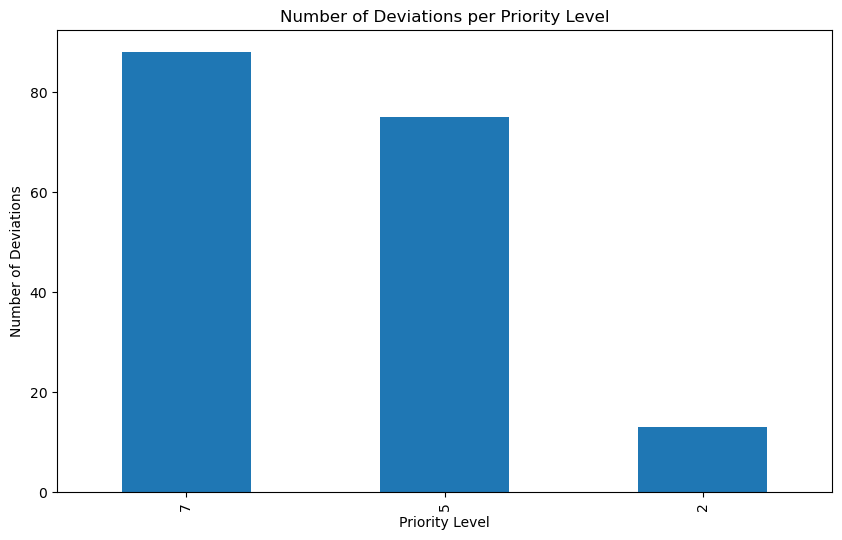

In [138]:
# Plotting the deviations data
plt.figure(figsize=(10, 6))
if 'priority.importance_level' in deviations.columns:
    deviations_priority = deviations['priority.importance_level'].value_counts()
    deviations_priority.plot(kind='bar')
    plt.xlabel('Priority Level')
    plt.ylabel('Number of Deviations')
    plt.title('Number of Deviations per Priority Level')
    plt.show()
else:
    print("The column 'priority.importance_level' is not present in deviations_df.")

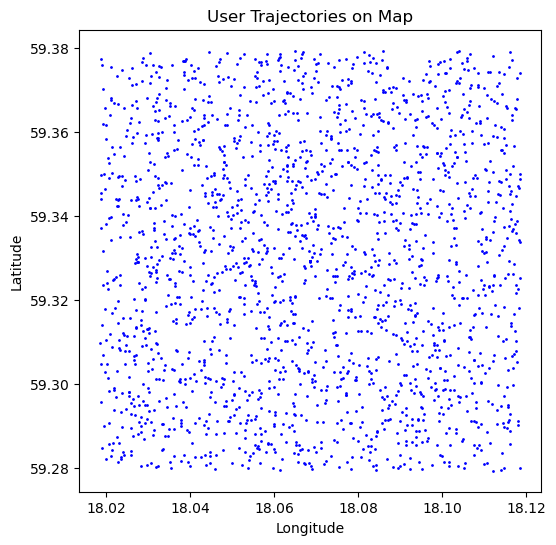

In [139]:
# Convert user trajectories DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(ut_df, geometry=gpd.points_from_xy(ut_df.Longitude, ut_df.Latitude))

# Plotting the trajectories on a map
gdf.plot(marker='o', color='blue', markersize=1, figsize=(10, 6))
plt.title('User Trajectories on Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [140]:
pt = pd.DataFrame(pd.read_pickle('personalized_timetable.pkl'))
pt

,transport_mode,line_id,line_name,designation,group_of_lines,transport_authority_id,transport_authority_name,contractor_id,contractor_name,valid_from,...,designation,transport_mode,line_name,group_of_lines,id,name,type,transport_authority,0,stop_points
0,metro,10,Blå linjen,10,Tunnelbanans blå linje,1,Storstockholms Lokaltrafik,25.0,MTR,2007-08-24T00:00:00,...,10,METRO,Blå linjen,tunnelbanans blå linje,3471.0,Tensta,METROSTN,1.0,NaN,None
1,metro,10,Blå linjen,10,Tunnelbanans blå linje,1,Storstockholms Lokaltrafik,25.0,MTR,2007-08-24T00:00:00,...,10,METRO,Blå linjen,tunnelbanans blå linje,1151.0,Fridhemsplan,METROSTN,1.0,NaN,None
2,metro,10,Blå linjen,10,Tunnelbanans blå linje,1,Storstockholms Lokaltrafik,25.0,MTR,2007-08-24T00:00:00,...,10,METRO,Blå linjen,tunnelbanans blå linje,3161.0,Stadshagen,METROSTN,1.0,NaN,None
3,metro,10,Blå linjen,10,Tunnelbanans blå linje,1,Storstockholms Lokaltrafik,25.0,MTR,2007-08-24T00:00:00,...,10,METRO,Blå linjen,tunnelbanans blå linje,1051.0,T-Centralen,METROSTN,1.0,NaN,None
4,metro,11,Blå linjen,11,Tunnelbanans blå linje,1,Storstockholms Lokaltrafik,25.0,MTR,2007-08-24T00:00:00,...,11,METRO,Blå linjen,tunnelbanans blå linje,1151.0,Fridhemsplan,METROSTN,1.0,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,bus,961,Närtrafiken Täby,961,Närtrafiken,1,Storstockholms Lokaltrafik,45.0,Transdev,2022-11-05T00:00:00,...,961,BUS,Närtrafiken Täby,Närtrafiken,81675.0,Åkerbyparken,BUSTERM,1.0,NaN,"[{'id': 81675, 'name': 'Åkerbyparken'}]"
403,bus,961,Närtrafiken Täby,961,Närtrafiken,1,Storstockholms Lokaltrafik,45.0,Transdev,2022-11-05T00:00:00,...,961,BUS,Närtrafiken Täby,Närtrafiken,81675.0,Åkerbyparken,BUSTERM,1.0,NaN,"[{'id': 81675, 'name': 'Åkerbyparken'}]"
404,bus,981,,981,Närtrafiken,1,Storstockholms Lokaltrafik,30.0,Nobina,2015-06-19T00:00:00,...,981,BUS,NaN,Närtrafiken,85073.0,Vallagården,BUSTERM,1.0,NaN,None
405,ship,83,,83,Pendelbåt,1,Storstockholms Lokaltrafik,5.0,Blidösundsbolaget,2020-07-09T00:00:00,...,83,SHIP,NaN,Pendelbåt,8024.0,Norra Tynningö,SHIPBER,1.0,NaN,None


In [141]:
# Merge duplicate columns.
def merge_duplicate_columns(df):
    cols_to_merge = df.columns[df.columns.duplicated(keep=False)]
    unique_cols = cols_to_merge.unique()

    for col in unique_cols:
        if col != '0':  # Skip the empty column '0'
            # Combine values columns.
            combined_col = df.loc[:, df.columns == col].apply(lambda x: x.dropna().unique().tolist(), axis=1)
            df[col] = combined_col

    # Remove duplicate columns
    df = df.loc[:, ~df.columns.duplicated()]
    return df

In [142]:
# Merge duplicate columns
personalized_timetable = merge_duplicate_columns(pt)

# Drop the empty column '0'
if '0' in personalized_timetable.columns:
    personalized_timetable = personalized_timetable.drop(columns=['0'])

# Save the updated DataFrame back to a pickle file
personalized_timetable.to_pickle('personalized_timetable_updated.pkl')

# Display the updated DataFrame
print(personalized_timetable.head())

   transport_mode line_id     line_name designation  \
0  [metro, METRO]    [10]  [Blå linjen]        [10]   
1  [metro, METRO]    [10]  [Blå linjen]        [10]   
2  [metro, METRO]    [10]  [Blå linjen]        [10]   
3  [metro, METRO]    [10]  [Blå linjen]        [10]   
4  [metro, METRO]    [11]  [Blå linjen]        [11]   

                                     group_of_lines  transport_authority_id  \
0  [Tunnelbanans blå linje, tunnelbanans blå linje]                       1   
1  [Tunnelbanans blå linje, tunnelbanans blå linje]                       1   
2  [Tunnelbanans blå linje, tunnelbanans blå linje]                       1   
3  [Tunnelbanans blå linje, tunnelbanans blå linje]                       1   
4  [Tunnelbanans blå linje, tunnelbanans blå linje]                       1   

     transport_authority_name  contractor_id contractor_name  \
0  Storstockholms Lokaltrafik           25.0             MTR   
1  Storstockholms Lokaltrafik           25.0             MTR   
2 